# Convolutional GAN
```GAN 02 - Convolutional, 64x64 output ```

Used Yun Chen's code for reference: https://github.com/chenyuntc/pytorch-GAN

### Importing libraries and dataset

In [5]:
# import the dataset class (64x64 images)
import dataset02 as dataset

# python imports
import itertools
import math
import time
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

# pytorch imports
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as tf
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [6]:
# This opens the HDF5 database and allows us to query it
data = dataset.get_dataset()
print("there are", len(data), "images in this dataset")

there are 30650 images in this dataset


### Creating a dataloader 

In [7]:
# Setting threads (num_workers) to 0 as suggested at https://discuss.pytorch.org/t/dataloader-iteration-hang-up/12886/3
threads = 0 # can increase this to have more data preloading, useful if your CPU cant keep up with GPU
batchSize = 32
shuffle = True # Shuffles the dataset before loading batches
cuda = True

train_loader = DataLoader(dataset=data, num_workers=threads, batch_size=batchSize, shuffle=shuffle, pin_memory=cuda)

### Hyperparameters

In [8]:
lr = 0.0002 # learning rate
noisedim = 100 # noise dimension
image_size = 64
image_size2 = 64
nc = 1 # channel of img 
ngf = 64 # generate channel
ndf = 64 # discriminative channel
beta1 = 0.5
num_epochs = 25 # =1 when debug
num_batches = len(train_loader)

print('There are ' + str(num_batches) + ' batches')

There are 958 batches


### Model set-up

In [9]:
discriminator = nn.Sequential(
        nn.Conv2d(nc,ndf,4,2,1,bias=False),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf,ndf*2,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf*2,ndf*4,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*4),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf*4,ndf*8,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*8),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf*8,1,4,1,0,bias=False),
        nn.Sigmoid()
    ).cuda()

In [10]:
generator= nn.Sequential(
        nn.ConvTranspose2d(noisedim,ngf*8,4,1,0,bias=False),
        nn.BatchNorm2d(ngf*8),
        nn.ReLU(True),

        nn.ConvTranspose2d(ngf*8,ngf*4,4,2,1,bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(True),

        nn.ConvTranspose2d(ngf*4,ngf*2,4,2,1,bias=False),
        nn.BatchNorm2d(ngf*2),
        nn.ReLU(True),

        nn.ConvTranspose2d(ngf*2,ngf,4,2,1,bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),

        nn.ConvTranspose2d(ngf,nc,4,2,1,bias=False),
        nn.Tanh()
    ).cuda()

### Optimization

In [11]:
# Binary Cross Entropy loss
criterion = nn.BCELoss()

d_optimizer = torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(beta1,0.999))
g_optimizer = torch.optim.Adam(generator.parameters(),lr=lr,betas=(beta1,0.999))

### Training

In [12]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs
    
    outputs = discriminator(fake_images) 
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [13]:
def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels)
    g_loss.backward()
    g_optimizer.step()
    
    return g_loss

In [14]:
# draw samples from the input distribution to inspect the generation on training 
num_test_samples = 25
fix_noise = Variable(torch.FloatTensor(num_test_samples, noisedim, 1, 1).normal_(0,1)).cuda()

### Execute training and sampling

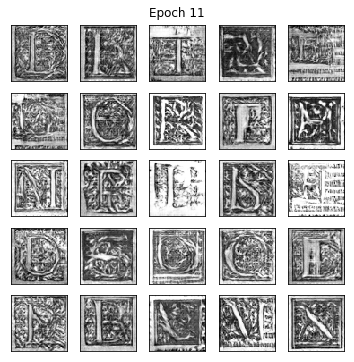

Epoch [12/25], Step[950/958], d_loss: 0.1040, g_loss: 2.5812, D(x): 0.95, D(G(z)): 0.04
Working on epoch 12 ...


In [ ]:
# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)


for epoch in range(num_epochs):
    print('Working on epoch ' + str(epoch) + ' ...')
    for n, (images, letters, countries, cities, names) in enumerate(train_loader):
        images = Variable(images.cuda())
        real_labels = Variable(torch.ones(images.size(0)).cuda())
        
        # Sample from generator
        noise = torch.randn(images.size(0),noisedim,1,1)
        noise = Variable(noise).cuda()
        
        fake_images = generator(noise)
        fake_labels = Variable(torch.zeros(images.size(0)).cuda())
        
        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
        
        # Sample again from the generator and get output from discriminator
        noise = torch.randn(images.size(0),noisedim,1,1)
        noise = Variable(noise).cuda()
        
        fake_images = generator(noise)
        outputs = discriminator(fake_images)
        
        # Train the generator
        g_loss = train_generator(generator, outputs, real_labels)
        
        # For every hundred batches show and save a plot of output
        if (n+1) % 190 == 0:
            step = 0
            test_images = generator(fix_noise)
            
            for k in range(num_test_samples):
                i = k//5
                j = k%5
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(64, 64), cmap='gray')
            display.clear_output(wait=True)
            plt.title("Epoch " + str(epoch), y=5.85, x=-1.98)
            display.display(plt.gcf())
            
            plt.savefig('Z:/GAN-Training-Results/Convolutional_64x64_32bs/result_' + str(epoch+1) + '-' + str(n+1) + '.png')
            step += 1
            
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
                  'D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch + 1, num_epochs, n+1, num_batches, d_loss.data[0], g_loss.data[0],
                    real_score.data.mean(), fake_score.data.mean()))